In [1]:
#imports
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

/Users/tim/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
#get data
master_df= pickle.load(open("ratings_fin_sector_PROFITS_ONLY.p","rb"))
master_df.head()

,index,ticker,Name,company,financial year end (month),industry code,indicator,Q1-2009,Q2-2009,Q3-2009,...,sector-_Consumer Staples,sector-_Energy,sector-_Financials,sector-_Health Care,sector-_Industrials,sector-_Information Technology,sector-_Materials,sector-_Real Estate,sector-_Telecommunication Services,sector-_Utilities
0,2,MMM,3M Company,3M,12,100001,Net Profit,518.0,783.0,957.0,...,0,0,0,0,1,0,0,0,0,0
1,6,AOS,A.O. Smith Corp,Smith A O Corp,12,100001,Net Profit,2.0,21.0,34.0,...,0,0,0,0,1,0,0,0,0,0
2,10,ABT,Abbott Laboratories,ABBOTT LABORATORIES,12,106004,Net Profit,1438.0,1288.0,1480.0,...,0,0,0,1,0,0,0,0,0,0
3,14,ABBV,AbbVie Inc.,AbbVie Inc.,NaN,106005,Net Profit,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,18,ACN,Accenture plc,Accenture plc,NaN,108002,Net Profit,479.0,411.0,443.0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
# add a squared term for profit, to see if any of that weird outlier stuff gets captured

master_df["Q4-2016 profit_squared"] = master_df["Q4-2016"].map(lambda x: x**2)

print(master_df[["Q4-2016","Q4-2016 profit_squared"]])


     Q4-2016  Q4-2016 profit_squared
0     1155.0               1334025.0
1       82.0                  6724.0
2      798.0                636804.0
3     1391.0               1934881.0
4     1069.0               1142761.0
5      253.0                 64009.0
6       82.0                  6724.0
7      399.0                159201.0
8       62.0                  3844.0
9      -51.0                  2601.0
10    -949.0                900601.0
11     139.0                 19321.0
12     150.0                 22500.0
13     751.0                564001.0
14     126.0                 15876.0
15     394.0                155236.0
16      91.0                  8281.0
17     114.0                 12996.0
18     602.0                362404.0
19     -26.0                   676.0
20      93.0                  8649.0
21      47.0                  2209.0
22      74.0                  5476.0
23       NaN                     NaN
24     -71.0                  5041.0
25      10.0                   100.0
2

In [7]:
#quick comparison (this cell and next) between the two models, w/o + w squared term using OLS

# Simple Model, no square term
si_y, si_X = patsy.dmatrices("""Q("company_ratings") ~ 
                       Q("Q4-2016")
                       + Q("sector-_Consumer Staples")
                       + Q("sector-_Energy")  
                       + Q("sector-_Financials")
                       + Q("sector-_Health Care") 
                       + Q("sector-_Industrials")
                       + Q("sector-_Information Technology") 
                       + Q("sector-_Materials")
                       + Q("sector-_Real Estate") 
                       + Q("sector-_Telecommunication Services") 
                       + Q("sector-_Utilities")
                       """, data= master_df,
                       return_type="dataframe")

# note, the Q and quotes notation is to get the model to read the variable names properly
                         
    
si_model = sm.OLS(si_y,si_X)
si_fit = si_model.fit()
si_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q("company_ratings")   R-squared:                       0.106
Model:                              OLS   Adj. R-squared:                  0.082
Method:                   Least Squares   F-statistic:                     4.335
Date:                  Fri, 20 Jul 2018   Prob (F-statistic):           3.87e-06
Time:                          05:49:53   Log-Likelihood:                -7.7530
No. Observations:                   413   AIC:                             39.51
Df Residuals:                       401   BIC:                             87.79
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   3.8153      0.032    119.162      0.000       3.752       3.878
Q("Q4-2016")                             3.298e-05   1.07e-05      3.082      0.002    1.19e-05     5.4e-05
Q("sector-_Consumer Staples")               0.0318      0.058      0.546      0.585      -0.083       0.146
Q("sector-_Energy")                         0.1958      0.057      3.423      0.001       0.083       0.308
Q("sector-_Financials")                    -0.0518      0.046     -1.116      0.265      -0.143       0.039
Q("sector-_Health Care")                   -0.0256      0.047     -0.541      0.589      -0.119       0.067
Q("sector-_Industrials")                   -0.0669      0.046     -1.443      0.150      -0.158       0.024
Q("sector-_Information Technology")         0.1090      0.045      2.426      0.016       0.021       0.197
Q("sector-_Materials")                     -0.0014      0.063     -0.022      0.983      -0.126       0.123
Q("sector-_Real Estate")                    0.0414      0.060      0.687      0.492      -0.077       0.160
Q("sector-_Telecommunication Services")    -0.1587      0.149     -1.062      0.289      -0.452       0.135
Q("sector-_Utilities")                      0.1072      0.061      1.748      0.081      -0.013       0.228
==============================================================================
Omnibus:                       18.993   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.243
Skew:                          -0.471   Prob(JB):                     2.44e-05
Kurtosis:                       3.588   Cond. No.                     1.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
# Squared Model
sq_y, sq_X = patsy.dmatrices("""Q("company_ratings") ~ 
                       Q("Q4-2016") 
                       +Q("Q4-2016 profit_squared")
                       + Q("sector-_Consumer Staples")
                       + Q("sector-_Energy")  
                       + Q("sector-_Financials")
                       + Q("sector-_Health Care") 
                       + Q("sector-_Industrials")
                       + Q("sector-_Information Technology") 
                       + Q("sector-_Materials")
                       + Q("sector-_Real Estate") 
                       + Q("sector-_Telecommunication Services") 
                       + Q("sector-_Utilities")
                       """, data= master_df,
                       return_type="dataframe")

# note, the Q and quotes notation is to get the model to read the variable names properly
                         
    
sq_model = sm.OLS(sq_y,sq_X)
sq_fit = sq_model.fit()
sq_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Q("company_ratings")   R-squared:                       0.107
Model:                              OLS   Adj. R-squared:                  0.080
Method:                   Least Squares   F-statistic:                     3.984
Date:                  Fri, 20 Jul 2018   Prob (F-statistic):           7.76e-06
Time:                          05:52:01   Log-Likelihood:                -7.6427
No. Observations:                   413   AIC:                             41.29
Df Residuals:                       400   BIC:                             93.59
Df Model:                            12                                         
Covariance Type:              nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   3.8141      0.032    118.552      0.000       3.751       3.877
Q("Q4-2016")                             3.752e-05   1.45e-05      2.582      0.010    8.95e-06    6.61e-05
Q("Q4-2016 profit_squared")             -1.012e-09   2.19e-09     -0.462      0.644   -5.32e-09    3.29e-09
Q("sector-_Consumer Staples")               0.0335      0.058      0.574      0.566      -0.081       0.148
Q("sector-_Energy")                         0.1989      0.058      3.450      0.001       0.086       0.312
Q("sector-_Financials")                    -0.0512      0.047     -1.102      0.271      -0.143       0.040
Q("sector-_Health Care")                   -0.0257      0.047     -0.542      0.588      -0.119       0.067
Q("sector-_Industrials")                   -0.0664      0.046     -1.431      0.153      -0.158       0.025
Q("sector-_Information Technology")         0.1100      0.045      2.443      0.015       0.021       0.198
Q("sector-_Materials")                     -0.0007      0.063     -0.011      0.991      -0.125       0.124
Q("sector-_Real Estate")                    0.0419      0.060      0.696      0.487      -0.077       0.160
Q("sector-_Telecommunication Services")    -0.1591      0.150     -1.064      0.288      -0.453       0.135
Q("sector-_Utilities")                      0.1110      0.062      1.792      0.074      -0.011       0.233
==============================================================================
Omnibus:                       18.896   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.019
Skew:                          -0.473   Prob(JB):                     2.73e-05
Kurtosis:                       3.571   Cond. No.                     9.88e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.88e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#Square term doesn't seem helpful, both no increase in Rsquare or adjusted Rsquare
# and non-significant value for square term

#  Now try full on Lasso feature engineering, for squared term, and interaction terms

In [11]:
# Create interaction terms
import re


column_names_l = list(master_df.columns.values)


def sector_func(column_names):
    sectors = []
    for column in column_names:
        sector_re = re.compile("sector-")
        if sector_re.match(column):
            sectors.append(column)
    return(sectors)

sector_l = sector_func(column_names_l)
print(sector_l)
    
    



['sector-_Consumer Discretionary', 'sector-_Consumer Staples', 'sector-_Energy', 'sector-_Financials', 'sector-_Health Care', 'sector-_Industrials', 'sector-_Information Technology', 'sector-_Materials', 'sector-_Real Estate', 'sector-_Telecommunication Services', 'sector-_Utilities']


In [14]:
# Create IX profits and industry
def mult(x,y):
    return (x * y)

sector_IX_l = []
for sector in sector_l:
    sector_IX = sector + "_p_IX"
    master_df[sector_IX] = np.vectorize(mult)(
    master_df["Q4-2016"],master_df[sector])
    sector_IX_l.append(sector_IX)
    
    
print(master_df[["sector-_Consumer Discretionary", "sector-_Consumer Discretionary_p_IX", 
                "Q4-2016"]] )


    





     sector-_Consumer Discretionary  sector-_Consumer Discretionary_p_IX  \
0                                 0                                  0.0   
1                                 0                                  0.0   
2                                 0                                  0.0   
3                                 0                                  0.0   
4                                 0                                  0.0   
5                                 0                                  0.0   
6                                 0                                  0.0   
7                                 0                                  0.0   
8                                 1                                 62.0   
9                                 0                                 -0.0   
10                                0                                 -0.0   
11                                0                                  0.0   
12          

In [23]:
# Full Monty on the feature engineering with LASSO-

X_list = ["Q4-2016","Q4-2016 profit_squared"] + sector_l + sector_IX_l

lasso_df_l = X_list + ["company_ratings"]
lasso_df = pd.DataFrame()
lasso_df[lasso_df_l] = master_df[lasso_df_l]

lasso_df = lasso_df.dropna(how = "any").reset_index()


X = lasso_df[X_list]

y = lasso_df["company_ratings"]
y = y.values.reshape(-1,1)




     index  Q4-2016  Q4-2016 profit_squared  sector-_Consumer Discretionary  \
0        0   1155.0               1334025.0                               0   
1        1     82.0                  6724.0                               0   
2        2    798.0                636804.0                               0   
3        3   1391.0               1934881.0                               0   
4        4   1069.0               1142761.0                               0   
5        5    253.0                 64009.0                               0   
6        6     82.0                  6724.0                               0   
7        7    399.0                159201.0                               0   
8        8     62.0                  3844.0                               1   
9        9    -51.0                  2601.0                               0   
10      10   -949.0                900601.0                               0   
11      11    139.0                 19321.0         

In [27]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify= X[sector_l], 
                                                    test_size=0.2)  #wow, stratify is really cool




# Show the plot of the Mean-Square values between the train test splits...
#

#Validate/grid-search
#Test?



     Q4-2016  Q4-2016 profit_squared  sector-_Consumer Discretionary  \
210   3562.0              12687844.0                               0   
315    100.0                 10000.0                               1   
47    -182.0                 33124.0                               0   
60      52.0                  2704.0                               0   
409    153.0                 23409.0                               0   
328    185.0                 34225.0                               0   
19     -26.0                   676.0                               0   
377   1144.0               1308736.0                               0   
272    190.0                 36100.0                               0   
393    651.0                423801.0                               0   
367    157.0                 24649.0                               1   
218     75.0                  5625.0                               0   
8       62.0                  3844.0                            

In [28]:
# scale data  
from sklearn.preprocessing import StandardScaler

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import  Lasso

model_lasso = Lasso()
parameters = {'alpha': [1e-5,1e-3,1e-1,1,1e2, 1e3], 'fit_intercept': [True,False]}
grid = GridSearchCV(model_lasso,parameters, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_train_scaled, y_train)

/Users/tim/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tim/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tim/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/tim/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [1e-05, 0.001, 0.1, 1, 100.0, 1000.0], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [31]:

grid.cv_results_
# Ask Zach or Lara about the way to look for outliers, and generally interpretting
# these results
# in the mean scores the

{'mean_fit_time': array([ 0.02703199,  0.00571542,  0.0007266 ,  0.00342541,  0.0023603 ,
         0.00058217,  0.00100174,  0.00057096,  0.00065403,  0.00048013,
         0.00075736,  0.00047441]),
 'mean_score_time': array([ 0.00194983,  0.00028396,  0.00019221,  0.00022259,  0.00028439,
         0.00024104,  0.00026841,  0.00020361,  0.00024037,  0.00021482,
         0.00028343,  0.00021377]),
 'mean_test_score': array([-0.21216599, -7.19138107, -0.20971336, -7.16522804, -0.2030326 ,
        -5.51521105, -0.2030326 , -3.80909091, -0.2030326 , -3.80909091,
        -0.2030326 , -3.80909091]),
 'mean_train_score': array([-0.18266152, -3.01298338, -0.18276296, -3.01413674, -0.20193641,
        -3.38256087, -0.20193641, -3.80909091, -0.20193641, -3.80909091,
        -0.20193641, -3.80909091]),
 'param_alpha': masked_array(data = [1e-05 1e-05 0.001 0.001 0.1 0.1 1 1 100.0 100.0 1000.0 1000.0],
              mask = [False False False False False False False False False False False False],


In [32]:
#get the best model from the Lasso
best_lasso = grid.best_estimator_



In [36]:
betas = best_lasso.coef_.round(5)
for beta in betas:
    print(betas)
print(len(betas))

[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0. -0.  0.  0.  0.
  0.  0. -0. -0. -0.  0.]
[ 0.  0. -

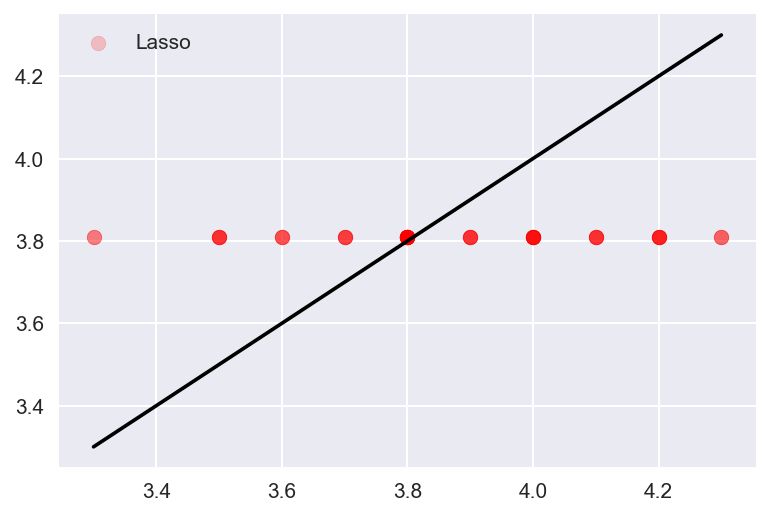

In [39]:
#then use that model
X_test_scaled = ssX.transform(X_test)
lasso_pred = best_lasso.predict(X_test_scaled)
lasso_pred = best_lasso.predict(X_test_scaled)

plt.figure(dpi=150)
plt.scatter(y_test, lasso_pred, label="Lasso", c='r', alpha=0.2)
plt.plot([min(y_test), max(y_test)],[min(y_test), max(y_test)],'k', zorder=20)
plt.legend(loc="upper left");

# Since in the "best fitting" lasso model has all of the Betas are zero,
# on the plot of the test values, for every test value offered, the prediction is just
# the intercept (all the x information is "lost" due to multiplying by zero)